In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
base_path = '../../'
sys.path.append(base_path)

In [3]:


from torch import nn
import torch

"""
3D U-Net: Learning Dense Volumetric Segmentation from Sparse Annotation
Paper URL: https://arxiv.org/abs/1606.06650
Author: Amir Aghdam
"""

class Conv3DBlock(nn.Module):
    """
    The basic block for double 3x3x3 convolutions in the analysis path
    -- __init__()
    :param in_channels -> number of input channels
    :param out_channels -> desired number of output channels
    :param bottleneck -> specifies the bottlneck block
    -- forward()
    :param input -> input Tensor to be convolved
    :return -> Tensor
    """

    def __init__(self, in_channels, out_channels, bottleneck = False) -> None:
        super(Conv3DBlock, self).__init__()
        self.conv1 = nn.Conv3d(in_channels= in_channels, out_channels=out_channels//2, kernel_size=(3,3,3), padding=1)
        self.bn1 = nn.BatchNorm3d(num_features=out_channels//2)
        self.conv2 = nn.Conv3d(in_channels= out_channels//2, out_channels=out_channels, kernel_size=(3,3,3), padding=1)
        self.bn2 = nn.BatchNorm3d(num_features=out_channels)
        self.relu = nn.ReLU()
        self.bottleneck = bottleneck
        if not bottleneck:
            self.pooling = nn.MaxPool3d(kernel_size=(2,2,2), stride=2)

    
    def forward(self, input):
        res = self.relu(self.bn1(self.conv1(input)))
        res = self.relu(self.bn2(self.conv2(res)))
        out = None
        if not self.bottleneck:
            out = self.pooling(res)
        else:
            out = res
        return out, res




class UpConv3DBlock(nn.Module):
    """
    The basic block for upsampling followed by double 3x3x3 convolutions in the synthesis path
    -- __init__()
    :param in_channels -> number of input channels
    :param out_channels -> number of residual connections' channels to be concatenated
    :param last_layer -> specifies the last output layer
    :param num_classes -> specifies the number of output channels for dispirate classes
    -- forward()
    :param input -> input Tensor
    :param residual -> residual connection to be concatenated with input
    :return -> Tensor
    """

    def __init__(self, in_channels, res_channels=0, last_layer=False, num_classes=None) -> None:
        super(UpConv3DBlock, self).__init__()
        assert (last_layer==False and num_classes==None) or (last_layer==True and num_classes!=None), 'Invalid arguments'
        self.upconv1 = nn.ConvTranspose3d(in_channels=in_channels, out_channels=in_channels, kernel_size=(2, 2, 2), stride=2)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm3d(num_features=in_channels//2)
        self.conv1 = nn.Conv3d(in_channels=in_channels+res_channels, out_channels=in_channels//2, kernel_size=(3,3,3), padding=(1,1,1))
        self.conv2 = nn.Conv3d(in_channels=in_channels//2, out_channels=in_channels//2, kernel_size=(3,3,3), padding=(1,1,1))
        self.last_layer = last_layer
        if last_layer:
            self.conv3 = nn.Conv3d(in_channels=in_channels//2, out_channels=num_classes, kernel_size=(1,1,1))
            
        
    def forward(self, input, residual=None):
        out = self.upconv1(input)
        if residual!=None: out = torch.cat((out, residual), 1)
        out = self.relu(self.bn(self.conv1(out)))
        out = self.relu(self.bn(self.conv2(out)))
        if self.last_layer: out = self.conv3(out)
        return out
        



class UNet3D(nn.Module):
    """
    The 3D UNet model
    -- __init__()
    :param in_channels -> number of input channels
    :param num_classes -> specifies the number of output channels or masks for different classes
    :param level_channels -> the number of channels at each level (count top-down)
    :param bottleneck_channel -> the number of bottleneck channels 
    :param device -> the device on which to run the model
    -- forward()
    :param input -> input Tensor
    :return -> Tensor
    """
    
    def __init__(self, in_channels, num_classes, level_channels=[64, 128, 256, 512], bottleneck_channel=1024) -> None:
        super(UNet3D, self).__init__()
        level_1_chnls, level_2_chnls, level_3_chnls, level_4_chnls = level_channels[0], level_channels[1], level_channels[2], level_channels[3]
        self.a_block1 = Conv3DBlock(in_channels=in_channels, out_channels=level_1_chnls)
        self.a_block2 = Conv3DBlock(in_channels=level_1_chnls, out_channels=level_2_chnls)
        self.a_block3 = Conv3DBlock(in_channels=level_2_chnls, out_channels=level_3_chnls)
        self.a_block4 = Conv3DBlock(in_channels=level_3_chnls, out_channels=level_4_chnls)
        self.bottleNeck = Conv3DBlock(in_channels=level_4_chnls, out_channels=bottleneck_channel, bottleneck= True)
        self.s_block4 = UpConv3DBlock(in_channels=bottleneck_channel, res_channels=level_4_chnls)
        self.s_block3 = UpConv3DBlock(in_channels=level_4_chnls, res_channels=level_3_chnls)
        self.s_block2 = UpConv3DBlock(in_channels=level_3_chnls, res_channels=level_2_chnls)
        self.s_block1 = UpConv3DBlock(in_channels=level_2_chnls, res_channels=level_1_chnls, num_classes=num_classes, last_layer=True)

    
    def forward(self, input):
        #Analysis path forward feed
        out, residual_level1 = self.a_block1(input)
        out, residual_level2 = self.a_block2(out)
        out, residual_level3 = self.a_block3(out)
        out, residual_level4 = self.a_block4(out)
        out, _ = self.bottleNeck(out)

        #Synthesis path forward feed
        out = self.s_block4(out, residual_level4)
        out = self.s_block3(out, residual_level3)
        out = self.s_block2(out, residual_level2)
        out = self.s_block1(out, residual_level1)
        return out
model = UNet3D(in_channels=1, num_classes=5, level_channels=[16, 32, 64,128], bottleneck_channel=256)

In [4]:
from src.pyvista_flow_field_dataset import PyvistaFlowFieldDataset
from src.voxel_flow_field_dataset import VoxelFlowFieldDataset, VoxelFlowFieldDatasetConfig
ds_pv = PyvistaFlowFieldDataset.load_from_huggingface(num_samples=200)
#ds_voxel = VoxelFlowFieldDataset('datasets/voxels',VoxelFlowFieldDatasetConfig(ds_pv, resolution=(32,16,16)))
ds_voxel = VoxelFlowFieldDataset('datasets/voxels')
ds_voxel.normalize()

Found 333 files in repository 'peteole/CoolMucSmall'.
File 1/400: volume_design_1.cgns already exists. Skipping download.
File 2/400: volume_design_10.cgns already exists. Skipping download.
File 3/400: volume_design_1001.cgns already exists. Skipping download.
File 4/400: volume_design_1002.cgns already exists. Skipping download.
File 5/400: volume_design_1003.cgns already exists. Skipping download.
File 6/400: volume_design_1004.cgns already exists. Skipping download.
File 7/400: volume_design_1005.cgns already exists. Skipping download.
File 8/400: volume_design_1006.cgns already exists. Skipping download.
File 9/400: volume_design_1007.cgns already exists. Skipping download.
File 10/400: volume_design_1008.cgns already exists. Skipping download.
File 11/400: volume_design_1009.cgns already exists. Skipping download.
File 12/400: volume_design_101.cgns already exists. Skipping download.
File 13/400: volume_design_1010.cgns already exists. Skipping download.
File 14/400: volume_desig

In [5]:

import torch.utils.data as data
dataloader = data.DataLoader(ds_voxel.get_default_loadable_dataset(), batch_size=100, shuffle=True)

In [18]:
import torch.optim as optim
from tqdm import tqdm
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)
criterion = nn.MSELoss()
lr=2e-4
epochs=400
optimizer = optim.Adam(model.parameters(), lr=lr)
losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for x,y in dataloader:
        x, y = x.to(device), y.to(device)
        x=x.float().unsqueeze(-1)
        x = x.permute(0, 4, 1, 2, 3)  # (N, D, H, W, C) → (N, C, D, H, W)
        y = y.permute(0, 4, 1, 2, 3)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    losses.append(epoch_loss / len(dataloader))
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(dataloader)}")

Using device: cuda
Epoch 10/400, Loss: 0.2617950029671192
Epoch 20/400, Loss: 0.2295731157064438
Epoch 30/400, Loss: 0.3082458823919296
Epoch 40/400, Loss: 0.2189200520515442
Epoch 50/400, Loss: 0.603984147310257
Epoch 60/400, Loss: 0.1981540471315384
Epoch 70/400, Loss: 0.19088579714298248
Epoch 80/400, Loss: 0.2357555404305458
Epoch 90/400, Loss: 0.16854362934827805
Epoch 100/400, Loss: 0.20052016526460648
Epoch 110/400, Loss: 0.46289481222629547
Epoch 120/400, Loss: 0.23167477548122406
Epoch 130/400, Loss: 0.15182806551456451
Epoch 140/400, Loss: 0.1617528721690178
Epoch 150/400, Loss: 0.3044837415218353
Epoch 160/400, Loss: 0.3003012239933014
Epoch 170/400, Loss: 0.19968483597040176
Epoch 180/400, Loss: 0.28398654609918594
Epoch 190/400, Loss: 0.33345529437065125
Epoch 200/400, Loss: 0.14865756779909134
Epoch 210/400, Loss: 0.23304171487689018
Epoch 220/400, Loss: 0.23321710526943207
Epoch 230/400, Loss: 0.21363837271928787
Epoch 240/400, Loss: 0.13302253931760788
Epoch 250/400, Lo

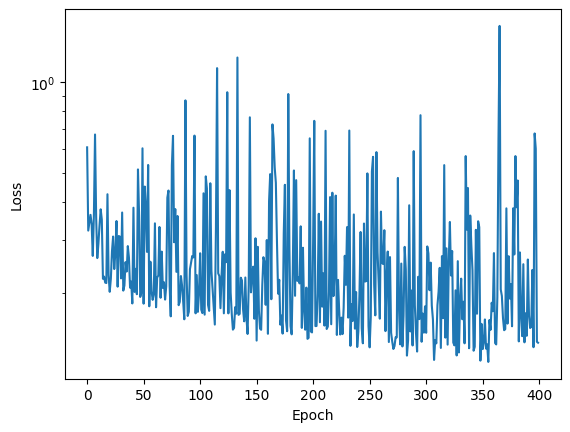

In [19]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

In [20]:
mask,Y = next(iter(dataloader))
mask = mask.to(device)
Y = Y.to(device)

In [21]:
x=mask.float().unsqueeze(-1)
x = x.permute(0, 4, 1, 2, 3)  # (N, D, H, W, C) → (N, C, D, H, W)
y = y.permute(0, 4, 1, 2, 3)
y_pred = model(x)
y_pred = y_pred.permute(0, 2, 3, 4, 1)  # (N, C, D, H, W) → (N, D, H, W, C)


In [22]:
y_pred.shape

torch.Size([100, 32, 16, 16, 5])

In [23]:
pred_sample = ds_voxel.prediction_to_sample(mask[0], y_pred[0])

In [24]:
pred_sample.plot("Pressure")

Widget(value='<iframe src="http://localhost:46459/index.html?ui=P_0x7049e012c890_2&reconnect=auto" class="pyvi…

In [25]:
true_sample = ds_voxel.prediction_to_sample(mask[0], Y[0])
true_sample.plot("Pressure")

Widget(value='<iframe src="http://localhost:46459/index.html?ui=P_0x704aa9f659d0_3&reconnect=auto" class="pyvi…

In [14]:
true_sample.normalization

{'Pressure': [45.944515228271484, 46.475826263427734],
 'Temperature': [189.76951599121094, 140.30227661132812],
 'Velocity': [[3.3776817321777344, 0.008169999346137047, 0.04333029314875603],
  [3.001274347305298, 0.46628230810165405, 0.29493123292922974]],
 'Position': [[0.20000003278255463,
   -0.015664581209421158,
   0.00976521335542202],
  [0.11914395540952682, 0.03080119751393795, 0.006291054654866457]]}